# Predicting the Outcome of Cricket Matches

## Introduction

In this project, we shall build a model which predicts the outcome of cricket matches in the Indian Premier League using data about matches and deliveries.

### Data Mining:

  * Season : 2008 - 2015 (8 Seasons)
  * Teams : DD, KKR, MI, RCB, KXIP, RR, CSK (7 Teams)
  * Neglect matches that have inconsistencies such as No Result, Tie, D/L Method, etc.

### Possible Features:

  * Average Batsman Rating (top 5) 
  * Average Bowler Rating (top 4)
  * Player of the match frequency 
  * Previous Encounter - Win by runs, Win by Wickets 
  * Recent form (Last 5 Games)
  * Venue - Home, Away, Neutral

In [60]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline 
#this line above prepares IPython notebook for working with matplotlib

# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().

import numpy as np # imports a fast numerical programming library
import scipy as sp #imports stats functions, amongst other things
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes
#sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns #sets up styles and gives us more plotting options
from __future__ import division

## Data Mining
  

In [61]:
# Reading in the data
allmatches = pd.read_csv("../data/matches.csv")
alldeliveries = pd.read_csv("../data/deliveries.csv")
allmatches.head(10)

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2008,Bangalore,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Kolkata Knight Riders,140,0,BB McCullum,M Chinnaswamy Stadium,Asad Rauf,RE Koertzen,NaN
1,2,2008,Chandigarh,2008-04-19,Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,bat,normal,0,Chennai Super Kings,33,0,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",MR Benson,SL Shastri,NaN
2,3,2008,Delhi,2008-04-19,Rajasthan Royals,Delhi Daredevils,Rajasthan Royals,bat,normal,0,Delhi Daredevils,0,9,MF Maharoof,Feroz Shah Kotla,Aleem Dar,GA Pratapkumar,NaN
3,4,2008,Mumbai,2008-04-20,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,normal,0,Royal Challengers Bangalore,0,5,MV Boucher,Wankhede Stadium,SJ Davis,DJ Harper,NaN
4,5,2008,Kolkata,2008-04-20,Deccan Chargers,Kolkata Knight Riders,Deccan Chargers,bat,normal,0,Kolkata Knight Riders,0,5,DJ Hussey,Eden Gardens,BF Bowden,K Hariharan,NaN
5,6,2008,Jaipur,2008-04-21,Kings XI Punjab,Rajasthan Royals,Kings XI Punjab,bat,normal,0,Rajasthan Royals,0,6,SR Watson,Sawai Mansingh Stadium,Aleem Dar,RB Tiffin,NaN
6,7,2008,Hyderabad,2008-04-22,Deccan Chargers,Delhi Daredevils,Deccan Chargers,bat,normal,0,Delhi Daredevils,0,9,V Sehwag,"Rajiv Gandhi International Stadium, Uppal",IL Howell,AM Saheba,NaN
7,8,2008,Chennai,2008-04-23,Chennai Super Kings,Mumbai Indians,Mumbai Indians,field,normal,0,Chennai Super Kings,6,0,ML Hayden,"MA Chidambaram Stadium, Chepauk",DJ Harper,GA Pratapkumar,NaN
8,9,2008,Hyderabad,2008-04-24,Deccan Chargers,Rajasthan Royals,Rajasthan Royals,field,normal,0,Rajasthan Royals,0,3,YK Pathan,"Rajiv Gandhi International Stadium, Uppal",Asad Rauf,MR Benson,NaN
9,10,2008,Chandigarh,2008-04-25,Kings XI Punjab,Mumbai Indians,Mumbai Indians,field,normal,0,Kings XI Punjab,66,0,KC Sangakkara,"Punjab Cricket Association Stadium, Mohali",Aleem Dar,AM Saheba,NaN


In [62]:
# Selecting Seasons 2008 - 2015
matches_seasons = allmatches.loc[allmatches['season'] != 2016]
deliveries_seasons = alldeliveries.loc[alldeliveries['match_id'] < 518]

In [63]:
# Selecting teams DD, KKR, MI, RCB, KXIP, RR, CSK
matches_teams = matches_seasons.loc[(matches_seasons['team1'].isin(['Kolkata Knight Riders', \
'Royal Challengers Bangalore', 'Delhi Daredevils', 'Chennai Super Kings', 'Rajasthan Royals', \
'Mumbai Indians', 'Kings XI Punjab'])) & (matches_seasons['team2'].isin(['Kolkata Knight Riders', \
'Royal Challengers Bangalore', 'Delhi Daredevils', 'Chennai Super Kings', 'Rajasthan Royals', \
'Mumbai Indians', 'Kings XI Punjab']))]
matches_teams.team1.unique()

array(['Kolkata Knight Riders', 'Chennai Super Kings', 'Rajasthan Royals',
       'Mumbai Indians', 'Kings XI Punjab', 'Royal Challengers Bangalore',
       'Delhi Daredevils'], dtype=object)

In [64]:
# Selecting teams DD, KKR, MI, RCB, KXIP, RR, CSK
matches_team_matchids = matches_teams.id.unique()
deliveries_teams = deliveries_seasons.loc[deliveries_seasons['match_id'].isin(matches_team_matchids)]
deliveries_teams.batting_team.unique()

array(['Kolkata Knight Riders', 'Royal Challengers Bangalore',
       'Chennai Super Kings', 'Kings XI Punjab', 'Rajasthan Royals',
       'Delhi Daredevils', 'Mumbai Indians'], dtype=object)

In [65]:
# Neglect matches with inconsistencies like 'No Result' or 'D/L Applied'
matches = matches_teams.loc[(matches_teams['result'] == 'normal') & (matches_teams['dl_applied'] == 0)]

In [66]:
# Neglect matches with inconsistencies like 'No Result' or 'D/L Applied'
matches_matchids = matches.id.unique()
deliveries = deliveries_teams.loc[deliveries_teams['match_id'].isin(matches_matchids)]

In [67]:
# Verifying consistency between datasets
(matches.id.unique() == deliveries.match_id.unique()).all()

True

# Building Features

In [68]:
# Team Strike rates for first 5 batsmen in the team (Higher the better)

def getMatchDeliveriesDF(match_id):
    return deliveries.loc[deliveries['match_id'] == match_id]

def getInningsOneBatsmen(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 1].batsman.unique()[0:5]

def getInningsTwoBatsmen(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 2].batsman.unique()[0:5]

def getBatsmanStrikeRate(batsman, match_id):
    onstrikedeliveries = deliveries.loc[(deliveries['match_id'] < match_id) & (deliveries['batsman'] == batsman)]
    total_runs = onstrikedeliveries['batsman_runs'].sum()
    total_balls = onstrikedeliveries.shape[0]
    if total_balls != 0: 
        return (total_runs/total_balls) * 100
    else:
        return None


def getTeamStrikeRate(batsmen, match_id):
    strike_rates = []
    for batsman in batsmen:
        bsr = getBatsmanStrikeRate(batsman, match_id)
        if bsr != None:
            strike_rates.append(bsr)
    return np.mean(strike_rates)

def getAverageStrikeRates(match_id):
    match_deliveries = getMatchDeliveriesDF(match_id)
    innOneBatsmen = getInningsOneBatsmen(match_deliveries)
    innTwoBatsmen = getInningsTwoBatsmen(match_deliveries)
    teamOneSR = getTeamStrikeRate(innOneBatsmen, match_id)
    teamTwoSR = getTeamStrikeRate(innTwoBatsmen, match_id)
    return teamOneSR, teamTwoSR

In [69]:
# Testing Functionality
getAverageStrikeRates(517)


(126.98024523159935, 128.55579510411653)

In [70]:
#New Column for Difference of Average Strike rates (First Team SR - Second Team SR) [Negative value means Second team is better]

firstTeamSR = []
secondTeamSR = []
for i in matches['id'].unique():
    P, Q = getAverageStrikeRates(i)
    firstTeamSR.append(P), secondTeamSR.append(Q)
firstSRSeries = pd.Series(firstTeamSR)
secondSRSeries = pd.Series(secondTeamSR)
matches["Avg_SR_Difference"] = firstSRSeries.values - secondSRSeries.values 

/Users/gursahej/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [71]:
#Testing 
matches.tail(8)

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,Avg_SR_Difference
506,507,2015,Chandigarh,2015-05-13,Kings XI Punjab,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Kings XI Punjab,22,0,AR Patel,"Punjab Cricket Association Stadium, Mohali",JD Cloete,C Shamshuddin,NaN,5.622383
507,508,2015,Mumbai,2015-05-14,Mumbai Indians,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Mumbai Indians,5,0,HH Pandya,Wankhede Stadium,RK Illingworth,VA Kulkarni,NaN,-0.677689
509,510,2015,Chandigarh,2015-05-16,Kings XI Punjab,Chennai Super Kings,Kings XI Punjab,bat,normal,0,Chennai Super Kings,0,7,P Negi,"Punjab Cricket Association Stadium, Mohali",CK Nandan,C Shamshuddin,NaN,-0.716536
510,511,2015,Mumbai,2015-05-16,Rajasthan Royals,Kolkata Knight Riders,Rajasthan Royals,bat,normal,0,Rajasthan Royals,9,0,SR Watson,Brabourne Stadium,RM Deshpande,RK Illingworth,NaN,-3.303823
513,514,2015,Mumbai,2015-05-19,Mumbai Indians,Chennai Super Kings,Mumbai Indians,bat,normal,0,Mumbai Indians,25,0,KA Pollard,Wankhede Stadium,HDPK Dharmasena,RK Illingworth,NaN,6.315981
514,515,2015,Pune,2015-05-20,Royal Challengers Bangalore,Rajasthan Royals,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,71,0,AB de Villiers,Maharashtra Cricket Association Stadium,AK Chaudhary,C Shamshuddin,NaN,-2.200375
515,516,2015,Ranchi,2015-05-22,Royal Challengers Bangalore,Chennai Super Kings,Chennai Super Kings,field,normal,0,Chennai Super Kings,0,3,A Nehra,JSCA International Stadium Complex,AK Chaudhary,CB Gaffaney,NaN,-0.521025
516,517,2015,Kolkata,2015-05-24,Mumbai Indians,Chennai Super Kings,Chennai Super Kings,field,normal,0,Mumbai Indians,41,0,RG Sharma,Eden Gardens,HDPK Dharmasena,RK Illingworth,NaN,-1.575550


In [72]:
# Bowler Rating : Wickets/Run (Higher the Better)
# Team 1: Batting First; Team 2: Fielding First

def getInningsOneBowlers(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 1].bowler.unique()[0:4]

def getInningsTwoBowlers(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 2].bowler.unique()[0:4]

def getBowlerWPR(bowler, match_id):
    balls = deliveries.loc[(deliveries['match_id'] < match_id) & (deliveries['bowler'] == bowler)]
    total_runs = balls['total_runs'].sum()
    total_wickets = balls.loc[balls['dismissal_kind'].isin(['caught', 'bowled', 'lbw', \
    'caught and bowled', 'stumped'])].shape[0]
    if total_runs != 0:
        return (total_wickets/total_runs) * 100
    else:
        return total_wickets

def getTeamWPR(bowlers, match_id):
    totalWPRs = []
    for bowler in bowlers:
        totalWPRs.append(getBowlerWPR(bowler, match_id))
    return np.mean(totalWPRs)

def getAverageWPR(match_id):
    match_deliveries = getMatchDeliveriesDF(match_id)
    innOneBowlers = getInningsOneBowlers(match_deliveries)
    innTwoBowlers = getInningsTwoBowlers(match_deliveries)
    teamOneWPR = getTeamWPR(innTwoBowlers, match_id)
    teamTwoWPR = getTeamWPR(innOneBowlers, match_id)
    return teamOneWPR, teamTwoWPR

In [73]:
#Testing Functionality 
getAverageWPR(517)

(2.7641806594085776, 4.4721111768026631)

In [74]:
#New Column for Difference of Wickets Per Run (First Team WPR - Second Team WPR) [Negative value means Second team is better]

firstTeamWPR = []
secondTeamWPR = []
for i in matches['id'].unique():
    R, S = getAverageWPR(i)
    firstTeamWPR.append(R), secondTeamWPR.append(S)
firstWPRSeries = pd.Series(firstTeamWPR)
secondWPRSeries = pd.Series(secondTeamWPR)
matches["Avg_WPR_Difference"] = firstWPRSeries.values - secondWPRSeries.values 

/Users/gursahej/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [75]:
#Testing
matches.tail(10)

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,Avg_SR_Difference,Avg_WPR_Difference
503,504,2015,Chennai,2015-05-10,Chennai Super Kings,Rajasthan Royals,Chennai Super Kings,bat,normal,0,Chennai Super Kings,12,0,RA Jadeja,"MA Chidambaram Stadium, Chepauk",M Erasmus,CK Nandan,NaN,-5.738591,-0.046456
505,506,2015,Raipur,2015-05-12,Chennai Super Kings,Delhi Daredevils,Chennai Super Kings,bat,normal,0,Delhi Daredevils,0,6,Z Khan,Shaheed Veer Narayan Singh International Stadium,RK Illingworth,VA Kulkarni,NaN,6.941454,1.678318
506,507,2015,Chandigarh,2015-05-13,Kings XI Punjab,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Kings XI Punjab,22,0,AR Patel,"Punjab Cricket Association Stadium, Mohali",JD Cloete,C Shamshuddin,NaN,5.622383,-1.324729
507,508,2015,Mumbai,2015-05-14,Mumbai Indians,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Mumbai Indians,5,0,HH Pandya,Wankhede Stadium,RK Illingworth,VA Kulkarni,NaN,-0.677689,-0.313345
509,510,2015,Chandigarh,2015-05-16,Kings XI Punjab,Chennai Super Kings,Kings XI Punjab,bat,normal,0,Chennai Super Kings,0,7,P Negi,"Punjab Cricket Association Stadium, Mohali",CK Nandan,C Shamshuddin,NaN,-0.716536,1.824407
510,511,2015,Mumbai,2015-05-16,Rajasthan Royals,Kolkata Knight Riders,Rajasthan Royals,bat,normal,0,Rajasthan Royals,9,0,SR Watson,Brabourne Stadium,RM Deshpande,RK Illingworth,NaN,-3.303823,-1.181868
513,514,2015,Mumbai,2015-05-19,Mumbai Indians,Chennai Super Kings,Mumbai Indians,bat,normal,0,Mumbai Indians,25,0,KA Pollard,Wankhede Stadium,HDPK Dharmasena,RK Illingworth,NaN,6.315981,-0.617777
514,515,2015,Pune,2015-05-20,Royal Challengers Bangalore,Rajasthan Royals,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,71,0,AB de Villiers,Maharashtra Cricket Association Stadium,AK Chaudhary,C Shamshuddin,NaN,-2.200375,0.969143
515,516,2015,Ranchi,2015-05-22,Royal Challengers Bangalore,Chennai Super Kings,Chennai Super Kings,field,normal,0,Chennai Super Kings,0,3,A Nehra,JSCA International Stadium Complex,AK Chaudhary,CB Gaffaney,NaN,-0.521025,1.039181
516,517,2015,Kolkata,2015-05-24,Mumbai Indians,Chennai Super Kings,Chennai Super Kings,field,normal,0,Mumbai Indians,41,0,RG Sharma,Eden Gardens,HDPK Dharmasena,RK Illingworth,NaN,-1.575550,-1.707931


In [76]:
# Man of the Match Awards for players of both Teams 

def getInningsOneAllBatsmen(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 1].batsman.unique()

def getInningsTwoAllBatsmen(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 2].batsman.unique()

def getInningsOneAllBowlers(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 2].bowler.unique()

def getInningsTwoAllBowlers(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 1].bowler.unique()

def getTeam(batsmen,bowlers):
    p = []
    p = np.append(p, batsmen)
    for i in bowlers:
        if i not in batsmen:
            p = np.append(p, i)
    return p

def getPlayerMVPAwards(player, match_id):
    return matches.loc[(matches["player_of_match"] == player) & (matches['id'] < match_id)].shape[0]

def getTeamMVPAwards(team, match_id):
    mvpAwards = 0
    for player in team:
        mvpAwards = mvpAwards + getPlayerMVPAwards(player,match_id)
    
    return mvpAwards

def bothTeamMVPAwards(match_id):
    matchDeliveries = getMatchDeliveriesDF(match_id)
    innOneBatsmen = getInningsOneAllBatsmen(matchDeliveries)
    innTwoBatsmen = getInningsTwoAllBatsmen(matchDeliveries)
    innOneBowlers = getInningsTwoAllBowlers(matchDeliveries)
    innTwoBowlers = getInningsOneAllBowlers(matchDeliveries)
    team1 = getTeam(innOneBatsmen, innTwoBowlers)
    
    team2 = getTeam(innTwoBatsmen, innOneBowlers)
    team1Awards = getTeamMVPAwards(team1,match_id)
    team2Awards = getTeamMVPAwards(team2,match_id)
    return team1Awards, team2Awards

        

 



In [77]:
#Testing Functionality
bothTeamMVPAwards(517)

(28, 52)

In [78]:
#New column for difference of MVP Awards (Negative value means Second team is better)

firstTeamMVP = []
secondTeamMVP = []
for i in matches['id'].unique():
    T, U = bothTeamMVPAwards(i)
    firstTeamMVP.append(T), secondTeamMVP.append(U)
firstMVPSeries = pd.Series(firstTeamMVP)
secondMVPSeries = pd.Series(secondTeamMVP)
matches["Total_MVP_Difference"] = firstMVPSeries.values - secondMVPSeries.values 

/Users/gursahej/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [79]:
#Testing 
matches.tail(5)

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,Avg_SR_Difference,Avg_WPR_Difference,Total_MVP_Difference
510,511,2015,Mumbai,2015-05-16,Rajasthan Royals,Kolkata Knight Riders,Rajasthan Royals,bat,normal,0,Rajasthan Royals,9,0,SR Watson,Brabourne Stadium,RM Deshpande,RK Illingworth,NaN,-3.303823,-1.181868,-16
513,514,2015,Mumbai,2015-05-19,Mumbai Indians,Chennai Super Kings,Mumbai Indians,bat,normal,0,Mumbai Indians,25,0,KA Pollard,Wankhede Stadium,HDPK Dharmasena,RK Illingworth,NaN,6.315981,-0.617777,-24
514,515,2015,Pune,2015-05-20,Royal Challengers Bangalore,Rajasthan Royals,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,71,0,AB de Villiers,Maharashtra Cricket Association Stadium,AK Chaudhary,C Shamshuddin,NaN,-2.200375,0.969143,5
515,516,2015,Ranchi,2015-05-22,Royal Challengers Bangalore,Chennai Super Kings,Chennai Super Kings,field,normal,0,Chennai Super Kings,0,3,A Nehra,JSCA International Stadium Complex,AK Chaudhary,CB Gaffaney,NaN,-0.521025,1.039181,-23
516,517,2015,Kolkata,2015-05-24,Mumbai Indians,Chennai Super Kings,Chennai Super Kings,field,normal,0,Mumbai Indians,41,0,RG Sharma,Eden Gardens,HDPK Dharmasena,RK Illingworth,NaN,-1.575550,-1.707931,-24


In [80]:
#Function to generate squad rating 

def generateSquadRating(match_id):
    gameday_teams = deliveries.loc[(deliveries['match_id'] == match_id)].batting_team.unique()
    teamOne = gameday_teams[0]
    teamTwo = gameday_teams[1]
    teamOneSR, teamTwoSR = getAverageStrikeRates(match_id)
    teamOneWPR, teamTwoWPR = getAverageWPR(match_id)
    teamOneMVPs, teamTwoMVPs = bothTeamMVPAwards(match_id)
    print "Comparing squads for {} vs {}".format(teamOne,teamTwo)
    print "\nAverage Strike Rate for Batsmen in {} : {}".format(teamOne,teamOneSR)
    print "\nAverage Strike Rate for Batsmen in {} : {}".format(teamTwo,teamTwoSR)
    print "\nBowler Rating (W/R) for {} : {}".format(teamOne,teamOneWPR)
    print "\nBowler Rating (W/R) for {} : {}".format(teamTwo,teamTwoWPR)
    print "\nNumber of MVP Awards in {} : {}".format(teamOne,teamOneMVPs)
    print "\nNumber of MVP Awards in {} : {}".format(teamTwo,teamTwoMVPs)

# graph test
men_means = (35)
men_std = (2)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, men_means, width, color='r', yerr=men_std)

women_means = (69)
women_std = (3)
rects2 = ax.bar(ind + width, women_means, width, color='y', yerr=women_std)

ax.set_ylabel('Scores')
ax.set_title('Scores by match')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Match'))

ax.legend((rects1[0], rects2[0]), ('Team1', 'Team2'))


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()


In [81]:
## 2nd Feature : Previous Encounter
# Won by runs and won by wickets (Higher the better)

def getTeam1(match_id):
    return matches.loc[matches["id"] == match_id].team1.unique()

def getTeam2(match_id):
    return matches.loc[matches["id"] == match_id].team2.unique()

def getPreviousEncDF(match_id):
    team1 = getTeam1(match_id)
    team2 = getTeam2(match_id)
    return matches.loc[(matches["id"] < match_id) & (((matches["team1"].isin(team1)) & (matches["team2"].isin(team2))) | ((matches["team1"].isin(team2)) & (matches["team2"].isin(team1))))].tail(8)

def getTeamWBR(match_id, team):
    WBR = 0
    DF = getPreviousEncDF(match_id)
    winnerDF = DF.loc[DF["winner"] == team]
    WBR = winnerDF['win_by_runs'].sum()    
    return WBR


def getTeamWBW(match_id, team):
    WBW = 0 
    DF = getPreviousEncDF(match_id)
    winnerDF = DF.loc[DF["winner"] == team]
    WBW = winnerDF['win_by_wickets'].sum()
    return WBW 
    
def getTeamWinPerc(match_id):
    dF = getPreviousEncDF(match_id)
    timesPlayed = dF.shape[0]
    team1 = getTeam1(match_id)[0].strip("[]")
    timesWon = dF.loc[dF["winner"] == team1].shape[0]
    if timesPlayed != 0:
        winPerc = (timesWon/timesPlayed) * 100
    else:
        winPerc = 0
    return winPerc

def getBothTeamStats(match_id):
    DF = getPreviousEncDF(match_id)
    team1 = getTeam1(match_id)[0].strip("[]")
    team2 = getTeam2(match_id)[0].strip("[]")
    timesPlayed = DF.shape[0]
    timesWon = DF.loc[DF["winner"] == team1].shape[0]
    WBRTeam1 = getTeamWBR(match_id, team1)
    WBRTeam2 = getTeamWBR(match_id, team2)
    WBWTeam1 = getTeamWBW(match_id, team1)
    WBWTeam2 = getTeamWBW(match_id, team2)

    print "Out of {} times in the past {} have won {} times({}%) from {}".format(timesPlayed, team1, timesWon, getTeamWinPerc(match_id), team2)
    print "{} won by {} total runs and {} total wickets.".format(team1, WBRTeam1, WBWTeam1)
    print "{} won by {} total runs and {} total wickets.".format(team2, WBRTeam2, WBWTeam2)




In [82]:
#Testing functionality 
getBothTeamStats(517)


Out of 8 times in the past Mumbai Indians have won 3 times(37.5%) from Chennai Super Kings
Mumbai Indians won by 48 total runs and 6 total wickets.
Chennai Super Kings won by 48 total runs and 24 total wickets.


In [83]:
#New column for win percentage of Team1 in previous encounter 

firstTeamWP = []
for i in matches['id'].unique():
    WP = getTeamWinPerc(i)
    firstTeamWP.append(WP)
firstWPSeries = pd.Series(firstTeamWP)
matches["Prev_Enc_Team1_WinPerc"] = firstWPSeries.values



/Users/gursahej/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [84]:
#Testing
matches.tail(5)

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,Avg_SR_Difference,Avg_WPR_Difference,Total_MVP_Difference,Prev_Enc_Team1_WinPerc
510,511,2015,Mumbai,2015-05-16,Rajasthan Royals,Kolkata Knight Riders,Rajasthan Royals,bat,normal,0,Rajasthan Royals,9,0,SR Watson,Brabourne Stadium,RM Deshpande,RK Illingworth,NaN,-3.303823,-1.181868,-16,37.5
513,514,2015,Mumbai,2015-05-19,Mumbai Indians,Chennai Super Kings,Mumbai Indians,bat,normal,0,Mumbai Indians,25,0,KA Pollard,Wankhede Stadium,HDPK Dharmasena,RK Illingworth,NaN,6.315981,-0.617777,-24,37.5
514,515,2015,Pune,2015-05-20,Royal Challengers Bangalore,Rajasthan Royals,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,71,0,AB de Villiers,Maharashtra Cricket Association Stadium,AK Chaudhary,C Shamshuddin,NaN,-2.200375,0.969143,5,50.0
515,516,2015,Ranchi,2015-05-22,Royal Challengers Bangalore,Chennai Super Kings,Chennai Super Kings,field,normal,0,Chennai Super Kings,0,3,A Nehra,JSCA International Stadium Complex,AK Chaudhary,CB Gaffaney,NaN,-0.521025,1.039181,-23,25.0
516,517,2015,Kolkata,2015-05-24,Mumbai Indians,Chennai Super Kings,Chennai Super Kings,field,normal,0,Mumbai Indians,41,0,RG Sharma,Eden Gardens,HDPK Dharmasena,RK Illingworth,NaN,-1.575550,-1.707931,-24,37.5


In [85]:
#3rd Feature: Recent Form (Win Percentage of all the previous matches of a team in the same season)
#Higher the better

def getMatchYear(match_id):
    return matches.loc[matches["id"] == match_id].season.unique()

def getTeam1DF(match_id, year):
    team1 = getTeam1(match_id)
    return matches.loc[(matches["id"] < match_id) & (matches["season"] == year) & ((matches["team1"].isin(team1)) | (matches["team2"].isin(team1)))]

def getTeam2DF(match_id, year):
    team2 = getTeam2(match_id)
    return matches.loc[(matches["id"] < match_id) & (matches["season"] == year) & ((matches["team1"].isin(team2)) | (matches["team2"].isin(team2)))]

def getTeamWinPercentage(match_id):
    win = 0
    total = 0
    year = int(getMatchYear(match_id))
    team1 = getTeam1(match_id)[0].strip("[]")
    team2 = getTeam2(match_id)[0].strip("[]")
    team1DF = getTeam1DF(match_id, year)
    team2DF = getTeam2DF(match_id, year)
    team1TotalMatches = team1DF.shape[0]
    team1WinMatches = team1DF.loc[team1DF["winner"] == team1].shape[0]
    team2TotalMatches = team2DF.shape[0]
    team2WinMatches = team2DF.loc[team2DF["winner"] == team2].shape[0]
    if (team1TotalMatches != 0) and (team2TotalMatches !=0):
        winPercTeam1 = ((team1WinMatches / team1TotalMatches) * 100) 
        winPercTeam2 = ((team2WinMatches / team2TotalMatches) * 100) 
    elif (team1TotalMatches != 0) and (team2TotalMatches ==0):
        winPercTeam1 = ((team1WinMatches / team1TotalMatches) * 100) 
        winPercTeam2 = 0
    elif (team1TotalMatches == 0) and (team2TotalMatches !=0):
        winPercTeam1 = 0
        winPercTeam2 = ((team2WinMatches / team2TotalMatches) * 100) 
    else:
        winPercTeam1 = 0
        winPercTeam2 = 0
        
    return winPercTeam1, winPercTeam2
    
    
def displayTeamWin(match_id):
    year = int(getMatchYear(match_id))
    team1 = getTeam1(match_id)[0].strip("[]")
    team2 = getTeam2(match_id)[0].strip("[]")
    P,Q = getTeamWinPercentage(match_id)
    print "In the season of {}, {} has a win percentage of {}% and {} has a win percentage of {}% ".format(year, team1, P, team2, Q)

In [86]:
#New column for Recent form(Win Percentage in the current season) of 1st Team compared to 2nd Team(Negative means 2nd team has higher win percentage)

firstTeamRF = []
secondTeamRF = []
for i in matches['id'].unique():
    K, L = getTeamWinPercentage(i)
    firstTeamRF.append(K), secondTeamRF.append(L)
firstRFSeries = pd.Series(firstTeamRF)
secondRFSeries = pd.Series(secondTeamRF)
matches["Total_RF_Difference"] = firstRFSeries.values - secondRFSeries.values 

/Users/gursahej/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [94]:
#Testing
matches.tail(5)

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,Avg_SR_Difference,Avg_WPR_Difference,Total_MVP_Difference,Prev_Enc_Team1_WinPerc,Total_RF_Difference
510,511,2015,Mumbai,2015-05-16,Rajasthan Royals,Kolkata Knight Riders,Rajasthan Royals,bat,normal,0,Rajasthan Royals,9,0,SR Watson,Brabourne Stadium,RM Deshpande,RK Illingworth,NaN,-3.303823,-1.181868,-16,37.5,2.500000
513,514,2015,Mumbai,2015-05-19,Mumbai Indians,Chennai Super Kings,Mumbai Indians,bat,normal,0,Mumbai Indians,25,0,KA Pollard,Wankhede Stadium,HDPK Dharmasena,RK Illingworth,NaN,6.315981,-0.617777,-24,37.5,-16.666667
514,515,2015,Pune,2015-05-20,Royal Challengers Bangalore,Rajasthan Royals,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,71,0,AB de Villiers,Maharashtra Cricket Association Stadium,AK Chaudhary,C Shamshuddin,NaN,-2.200375,0.969143,5,50.0,-6.666667
515,516,2015,Ranchi,2015-05-22,Royal Challengers Bangalore,Chennai Super Kings,Chennai Super Kings,field,normal,0,Chennai Super Kings,0,3,A Nehra,JSCA International Stadium Complex,AK Chaudhary,CB Gaffaney,NaN,-0.521025,1.039181,-23,25.0,2.097902
516,517,2015,Kolkata,2015-05-24,Mumbai Indians,Chennai Super Kings,Chennai Super Kings,field,normal,0,Mumbai Indians,41,0,RG Sharma,Eden Gardens,HDPK Dharmasena,RK Illingworth,NaN,-1.575550,-1.707931,-24,37.5,-10.439560


In [96]:
#Function to implement all features
def getAllFeatures(match_id):
    generateSquadRating(match_id)
    print ("\n")
    getBothTeamStats(match_id)
    print("\n")
    displayTeamWin(match_id)


In [90]:
#Testing Functionality
getAllFeatures(517)

Comparing squads for Mumbai Indians vs Chennai Super Kings

Average Strike Rate for Batsmen in Mumbai Indians : 126.980245232

Average Strike Rate for Batsmen in Chennai Super Kings : 128.555795104

Bowler Rating (W/R) for Mumbai Indians : 2.76418065941

Bowler Rating (W/R) for Chennai Super Kings : 4.4721111768

Number of MVP Awards in Mumbai Indians : 28

Number of MVP Awards in Chennai Super Kings : 52


Out of 8 times in the past Mumbai Indians have won 3 times(37.5%) from Chennai Super Kings
Mumbai Indians won by 48 total runs and 6 total wickets.
Chennai Super Kings won by 48 total runs and 24 total wickets.


In the season of 2015, Mumbai Indians has a win percentage of 53.8461538462% and Chennai Super Kings has a win percentage of 64.2857142857% 


# Graph


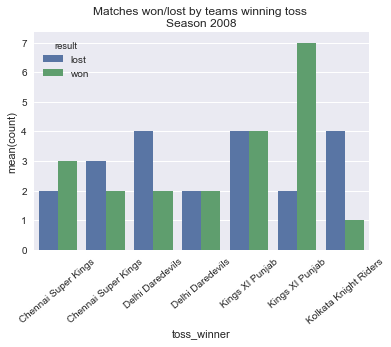

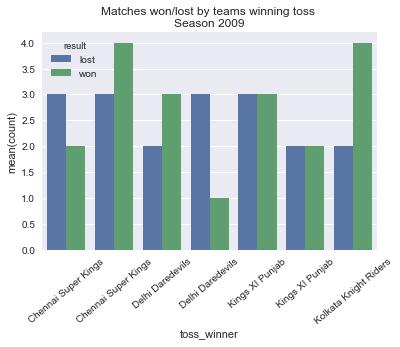

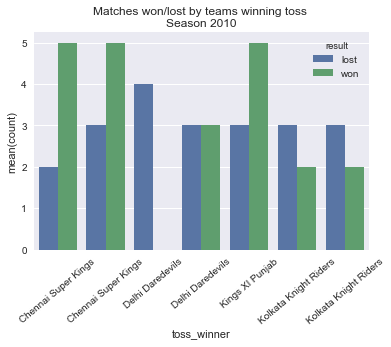

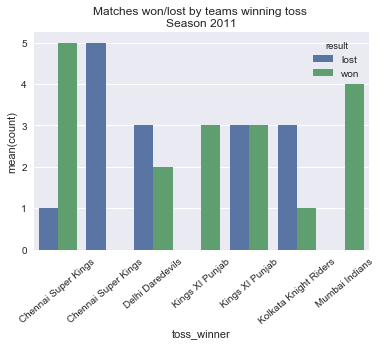

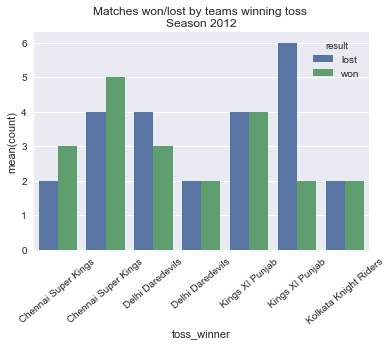

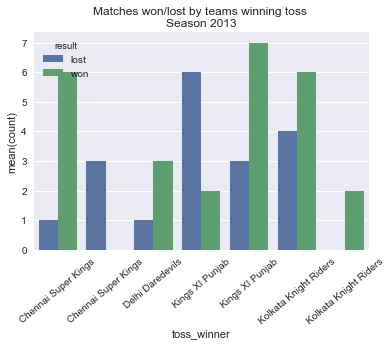

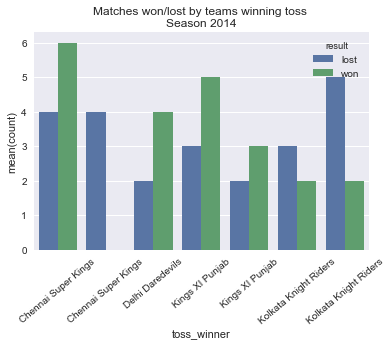

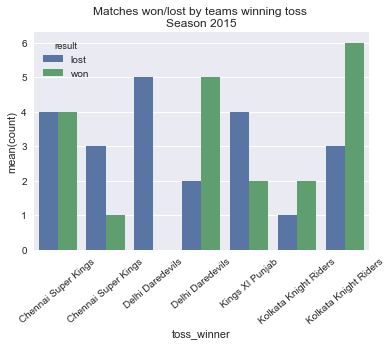

In [91]:
#toss effect
toss = matches.groupby(['season', 'toss_winner']).winner.value_counts().reset_index(name = 'count')
toss['result'] = np.where(toss.toss_winner == toss.winner, 'won', 'lost')
toss_result = toss.groupby(['season', 'toss_winner','result'])['count'].sum().reset_index()

for x in range(2008, 2016, 1):
    toss_result_x = toss_result[toss_result['season'] == x]
    plot = sns.barplot(x="toss_winner", y="count", hue="result", data=toss_result_x)
    plot.set_title('Matches won/lost by teams winning toss \nSeason ' +str(x))
    plot.set_xticklabels(toss_result_x['toss_winner'],rotation=40)
    plt.show()
    x+=1

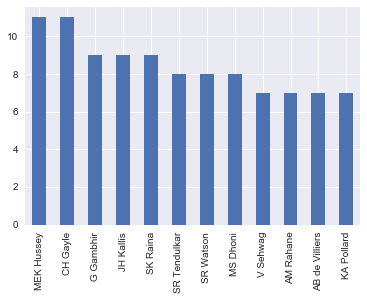

In [92]:
matches['player_of_match'].value_counts()[:12].plot(kind = 'bar')

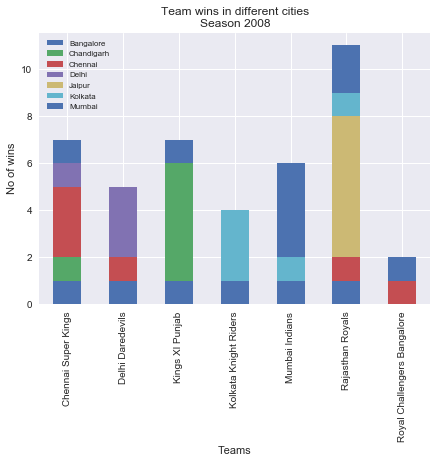

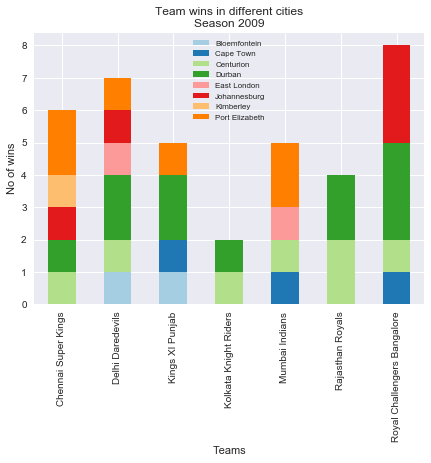

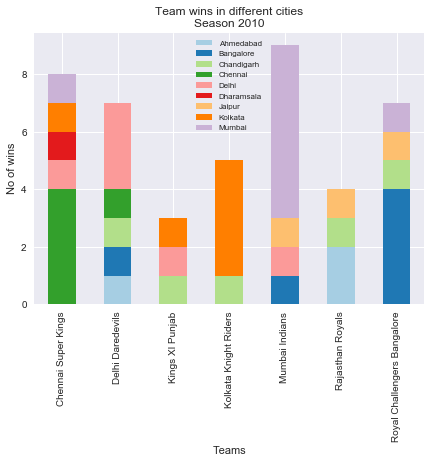

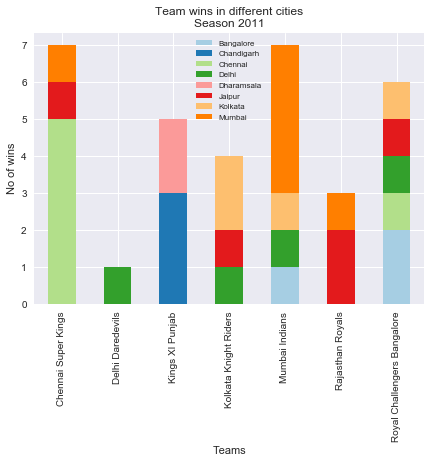

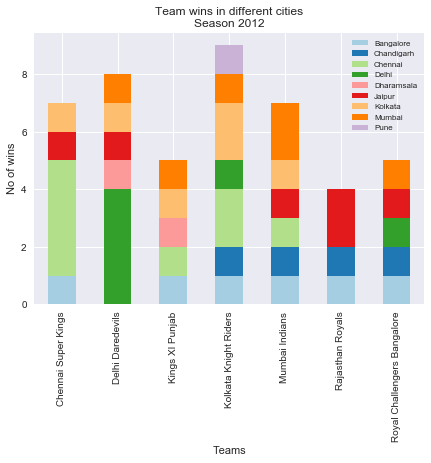

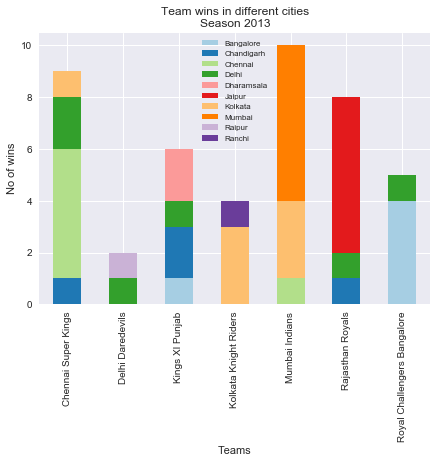

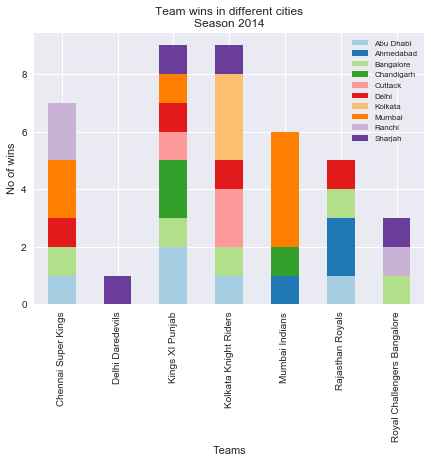

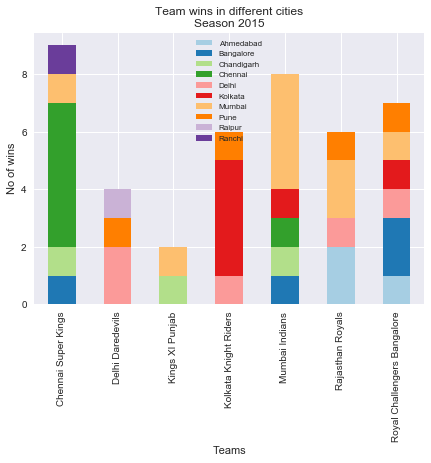

In [93]:
x, y = 2008, 2016
while x < y:
    wins_percity = matches[matches['season'] == x].groupby(['winner', 'city'])['id'].count().unstack()
    plot = wins_percity.plot(kind='bar', stacked=True, title="Team wins in different cities\nSeason "+str(x), figsize=(7, 5))
    sns.set_palette("Paired", len(matches['city'].unique()))
    plot.set_xlabel("Teams")
    plot.set_ylabel("No of wins")
    plot.legend(loc='best', prop={'size':8})
    x+=1